In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('../data/train.csv', low_memory=False)
test = pd.read_csv('../data/test.csv')

In [3]:
train.columns

Index(['city', 'floor', 'id', 'lat', 'lng', 'osm_amenity_points_in_0.001',
       'osm_amenity_points_in_0.005', 'osm_amenity_points_in_0.0075',
       'osm_amenity_points_in_0.01', 'osm_building_points_in_0.001',
       'osm_building_points_in_0.005', 'osm_building_points_in_0.0075',
       'osm_building_points_in_0.01', 'osm_catering_points_in_0.001',
       'osm_catering_points_in_0.005', 'osm_catering_points_in_0.0075',
       'osm_catering_points_in_0.01', 'osm_city_closest_dist',
       'osm_city_nearest_name', 'osm_city_nearest_population',
       'osm_crossing_closest_dist', 'osm_crossing_points_in_0.001',
       'osm_crossing_points_in_0.005', 'osm_crossing_points_in_0.0075',
       'osm_crossing_points_in_0.01', 'osm_culture_points_in_0.001',
       'osm_culture_points_in_0.005', 'osm_culture_points_in_0.0075',
       'osm_culture_points_in_0.01', 'osm_finance_points_in_0.001',
       'osm_finance_points_in_0.005', 'osm_finance_points_in_0.0075',
       'osm_finance_points_in

In [4]:
for c in test.columns:
    if train.loc[train[c].isnull()].shape[0] > 0:
        print(c)

floor
osm_city_nearest_population
reform_house_population_1000
reform_house_population_500
reform_mean_floor_count_1000
reform_mean_floor_count_500
reform_mean_year_building_1000
reform_mean_year_building_500
street


In [5]:
train['floor'].value_counts()

1.0               72871
2.0                8102
-1.0               8065
3.0                3682
4.0                2284
                  ...  
1-3                   1
мансарда (4эт)        1
1, 2.                 1
9                     1
3, мансарда           1
Name: floor, Length: 168, dtype: int64

In [6]:
test['floor'].value_counts()

1.0                                   591
1                                     391
-1.0                                  102
2.0                                    99
2                                      66
                                     ... 
подвал, 1, 2, 3                         1
1,2,3, антресоль, технический этаж      1
3, 4                                    1
4, 5                                    1
подвал,1                                1
Name: floor, Length: 74, dtype: int64

In [7]:
import json
with open('../data/russian-cities.json', 'r') as json_file:
    cities_data = json.load(json_file)
population_dict = {city_dict['name']: city_dict['population'] for city_dict in cities_data}
train['population'] = train['city'].map(population_dict)
test['population'] = test['city'].map(population_dict)

In [8]:
import re
pattern = r'[a-zа-я\s]'

train['floor_count_comma'] = train['floor'].str.count(',').fillna(0)
test['floor_count_comma'] = test['floor'].str.count(',').fillna(0)

train['floor']=train['floor'].fillna('missing').str.lower()
test['floor']=test['floor'].fillna('missing').str.lower()
train['floor']=train['floor'].str.replace(' ','')
test['floor']=test['floor'].str.replace(' ','')
train['floor']=train['floor'].str.replace('.0','', regex=False)
test['floor']=test['floor'].str.replace('.0','', regex=False)

train['floor_under'] = (train['floor'].str.count('подвал')  > 0).astype(int)
train['floor_upper'] = (train['floor'].str.count('мансарда') > 0).astype(int)
train['floor_ground'] = (train['floor'].str.count('цоколь') > 0).astype(int)
test['floor_under'] = (test['floor'].str.count('подвал')  > 0).astype(int)
test['floor_upper'] = (test['floor'].str.count('мансарда') > 0).astype(int)
test['floor_ground'] = (test['floor'].str.count('цоколь') > 0).astype(int)

def min_floor(s):
    x = 0
    try:
        x = int(s)
    except:
        pass
    if x == 0:
        try:
            ss = re.sub(pattern, '', s)
            if ss[0] == ',':
                ss = ss[1:]
            x = int(ss.split(',')[0])
        except:
            pass
    return x

def max_floor(s):
    x = 0
    try:
        x = int(s)
    except:
        pass
    if x == 0:
        try:
            ss = re.sub(pattern, '', s)
            if ss[-1] == ',':
                ss = ss[1:]
            x = int(ss.split(',')[-1])
        except:
            pass
    return x

train['num_min_floor'] = train['floor'].apply(min_floor).fillna(0)
test['num_min_floor'] = test['floor'].apply(min_floor).fillna(0)
train['num_max_floor'] = train['floor'].apply(max_floor).fillna(0)
test['num_max_floor'] = test['floor'].apply(max_floor).fillna(0)

In [9]:
train[['floor','floor_count_comma', 'num_min_floor', 'num_max_floor', 'population']].sample(10)

,floor,floor_count_comma,num_min_floor,num_max_floor,population
273166,0,0.0,0,0,1244254.0
125957,missing,0.0,0,0,12655050.0
268764,1,0.0,1,1,581758.0
57577,missing,0.0,0,0,12655050.0
64801,missing,0.0,0,0,12655050.0
259930,1,0.0,1,1,5384342.0
264077,1,0.0,1,1,12655050.0
32085,2,0.0,2,2,58983.0
238636,missing,0.0,0,0,5384342.0
10314,missing,0.0,0,0,12655050.0


In [10]:
TARGET = 'per_square_meter_price'
# признаки (или набор признаков), для которых применяем smoothed target encoding
CATEGORICAL_FEATURES = ['region', 'city', 'realty_type', 'street','floor','osm_city_nearest_name']

# численные признаки
NUM_FEATURES = ['lat', 'lng', 'osm_amenity_points_in_0.001',
       'osm_amenity_points_in_0.005', 'osm_amenity_points_in_0.0075',
       'osm_amenity_points_in_0.01', 'osm_building_points_in_0.001',
       'osm_building_points_in_0.005', 'osm_building_points_in_0.0075',
       'osm_building_points_in_0.01', 'osm_catering_points_in_0.001',
       'osm_catering_points_in_0.005', 'osm_catering_points_in_0.0075',
       'osm_catering_points_in_0.01', 'osm_city_closest_dist',
       'osm_city_nearest_population',
       'osm_crossing_closest_dist', 'osm_crossing_points_in_0.001',
       'osm_crossing_points_in_0.005', 'osm_crossing_points_in_0.0075',
       'osm_crossing_points_in_0.01', 'osm_culture_points_in_0.001',
       'osm_culture_points_in_0.005', 'osm_culture_points_in_0.0075',
       'osm_culture_points_in_0.01', 'osm_finance_points_in_0.001',
       'osm_finance_points_in_0.005', 'osm_finance_points_in_0.0075',
       'osm_finance_points_in_0.01', 'osm_healthcare_points_in_0.005',
       'osm_healthcare_points_in_0.0075', 'osm_healthcare_points_in_0.01',
       'osm_historic_points_in_0.005', 'osm_historic_points_in_0.0075',
       'osm_historic_points_in_0.01', 'osm_hotels_points_in_0.005',
       'osm_hotels_points_in_0.0075', 'osm_hotels_points_in_0.01',
       'osm_leisure_points_in_0.005', 'osm_leisure_points_in_0.0075',
       'osm_leisure_points_in_0.01', 'osm_offices_points_in_0.001',
       'osm_offices_points_in_0.005', 'osm_offices_points_in_0.0075',
       'osm_offices_points_in_0.01', 'osm_shops_points_in_0.001',
       'osm_shops_points_in_0.005', 'osm_shops_points_in_0.0075',
       'osm_shops_points_in_0.01', 'osm_subway_closest_dist',
       'osm_train_stop_closest_dist', 'osm_train_stop_points_in_0.005',
       'osm_train_stop_points_in_0.0075', 'osm_train_stop_points_in_0.01',
       'osm_transport_stop_closest_dist', 'osm_transport_stop_points_in_0.005',
       'osm_transport_stop_points_in_0.0075',
       'osm_transport_stop_points_in_0.01',
       'reform_count_of_houses_1000', 'reform_count_of_houses_500',
       'reform_house_population_1000', 'reform_house_population_500',
       'reform_mean_floor_count_1000', 'reform_mean_floor_count_500',
       'reform_mean_year_building_1000', 'reform_mean_year_building_500', 'total_square']

In [11]:
import pandas as pd
UNKNOWN_VALUE = 'missing'

def prepare_categorical(df: pd.DataFrame) -> pd.DataFrame:
    """
    Заполняет пропущенные категориальные переменные
    :param df: dataframe, обучающая выборка
    :return: dataframe
    """
    df_new = df.copy()
    fillna_cols = list(CATEGORICAL_FEATURES)
    df_new[fillna_cols] = df_new[fillna_cols].fillna(UNKNOWN_VALUE)
    return df_new
train = prepare_categorical(train)
test = prepare_categorical(test)

# в трейне те значения, которые встречаются только один раз заменяем на missing
for c in CATEGORICAL_FEATURES:
    q = train[c].value_counts()
    single = q.loc[q.values==1].index.tolist()
    changed_in_train = train.loc[train[c].isin(single),c].shape[0]
    changed_in_test = test.loc[train[c].isin(single),c].shape[0]
    train.loc[train[c].isin(single),c] = UNKNOWN_VALUE
    test.loc[test[c].isin(single),c] = UNKNOWN_VALUE
    print('category',c,'changed in train',changed_in_train,'changed in test',changed_in_test)

#убираем из теста те значения, которых нет в трейн
for c in CATEGORICAL_FEATURES:
    train_uniq = train[c].unique()
    count_changed = 0
    for v in test[c].unique():
        if v not in train_uniq:
            count_changed += test.loc[test[c] == v, c].shape[0]
            test.loc[test[c] == v, c] = UNKNOWN_VALUE
        if count_changed > 0:
            print('changed in category ', c, 'value', v, count_changed, 'times')

category region changed in train 0 changed in test 0
category city changed in train 1842 changed in test 18
category realty_type changed in train 0 changed in test 0
category street changed in train 14910 changed in test 343
category floor changed in train 35 changed in test 0
category osm_city_nearest_name changed in train 0 changed in test 0
changed in category  city value Ромашково 1 times
changed in category  city value Тобольск 1 times
changed in category  city value Курчатов 1 times
changed in category  city value Боброво 1 times
changed in category  city value Дрожжино 1 times
changed in category  city value Бердск 1 times
changed in category  city value Пенза 1 times
changed in category  city value Усинск 1 times
changed in category  city value Волжский 1 times
changed in category  city value Белокуриха 1 times
changed in category  city value Коммунар 1 times
changed in category  city value Нижнеудинск 1 times
changed in category  city value Кострома 1 times
changed in category

changed in category  street value S908 23 times
changed in category  street value S27450 23 times
changed in category  street value S13613 23 times
changed in category  street value S32134 23 times
changed in category  street value S4180 23 times
changed in category  street value S6137 23 times
changed in category  street value S6425 23 times
changed in category  street value S8628 23 times
changed in category  street value S11087 23 times
changed in category  street value S17146 23 times
changed in category  street value S20270 23 times
changed in category  street value S3195 24 times
changed in category  street value S8577 24 times
changed in category  street value S19850 24 times
changed in category  street value S10892 24 times
changed in category  street value S34071 25 times
changed in category  street value S9725 25 times
changed in category  street value S14239 25 times
changed in category  street value S12131 25 times
changed in category  street value S12097 25 times
changed i

changed in category  street value S8047 40 times
changed in category  street value S14491 40 times
changed in category  street value S11025 40 times
changed in category  street value S13631 40 times
changed in category  street value S17203 40 times
changed in category  street value S17637 40 times
changed in category  street value S7040 40 times
changed in category  street value S1064 40 times
changed in category  street value S707 40 times
changed in category  street value S9891 40 times
changed in category  street value S14317 41 times
changed in category  street value S14358 41 times
changed in category  street value S384 41 times
changed in category  street value S7834 41 times
changed in category  street value S6317 41 times
changed in category  street value S31879 41 times
changed in category  street value S30241 42 times
changed in category  street value S18825 42 times
changed in category  street value S11891 42 times
changed in category  street value S23839 42 times
changed in

changed in category  street value S9649 65 times
changed in category  street value S9110 65 times
changed in category  street value S27506 65 times
changed in category  street value S27289 65 times
changed in category  street value S10546 65 times
changed in category  street value S14395 65 times
changed in category  street value S8530 65 times
changed in category  street value S10628 65 times
changed in category  street value S23571 65 times
changed in category  street value S25941 65 times
changed in category  street value S13275 65 times
changed in category  street value S22375 65 times
changed in category  street value S14602 65 times
changed in category  street value S9781 65 times
changed in category  street value S24972 65 times
changed in category  street value S21780 65 times
changed in category  street value S11114 65 times
changed in category  street value S7609 65 times
changed in category  street value S7405 65 times
changed in category  street value S8146 65 times
changed

changed in category  street value S2638 87 times
changed in category  street value S2435 87 times
changed in category  street value S25636 87 times
changed in category  street value S335 87 times
changed in category  street value S6802 87 times
changed in category  street value S28905 87 times
changed in category  street value S13777 87 times
changed in category  street value S1909 87 times
changed in category  street value S27180 87 times
changed in category  street value S27214 87 times
changed in category  street value S18376 87 times
changed in category  street value S6382 87 times
changed in category  street value S3812 87 times
changed in category  street value S14603 87 times
changed in category  street value S968 87 times
changed in category  street value S1931 88 times
changed in category  street value S4101 88 times
changed in category  street value S10173 89 times
changed in category  street value S10643 90 times
changed in category  street value S25537 90 times
changed in c

changed in category  street value S1411 124 times
changed in category  street value S573 125 times
changed in category  street value S28505 125 times
changed in category  street value S30695 125 times
changed in category  street value S10250 126 times
changed in category  street value S27768 126 times
changed in category  street value S29253 127 times
changed in category  street value S21716 127 times
changed in category  street value S12640 128 times
changed in category  street value S6641 129 times
changed in category  street value S19506 129 times
changed in category  street value S9074 129 times
changed in category  street value S22817 129 times
changed in category  street value S1502 129 times
changed in category  street value S9707 129 times
changed in category  street value S26550 129 times
changed in category  street value S13698 130 times
changed in category  street value S93 130 times
changed in category  street value S32075 130 times
changed in category  street value S27295 

In [12]:
train['date'] = pd.to_datetime(train['date'])
train['month'] = train['date'].dt.month
test['date'] = pd.to_datetime(test['date'])
test['month'] = test['date'].dt.month

In [13]:
import typing
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error

THRESHOLD = 0.15
NEGATIVE_WEIGHT = 1.1


def deviation_metric_one_sample(y_true: typing.Union[float, int], y_pred: typing.Union[float, int]) -> float:
    """
    Реализация кастомной метрики для хакатона.

    :param y_true: float, реальная цена
    :param y_pred: float, предсказанная цена
    :return: float, значение метрики
    """
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    if np.abs(deviation) <= THRESHOLD:
        return 0
    elif deviation <= - 4 * THRESHOLD:
        return 9 * NEGATIVE_WEIGHT
    elif deviation < -THRESHOLD:
        return NEGATIVE_WEIGHT * ((deviation / THRESHOLD) + 1) ** 2
    elif deviation < 4 * THRESHOLD:
        return ((deviation / THRESHOLD) - 1) ** 2
    else:
        return 9


def deviation_metric(y_true: np.array, y_pred: np.array) -> float:
    return np.mean([deviation_metric_one_sample(y_true[n], y_pred[n]) for n in range(len(y_true))]) #.mean()

def median_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.median(np.abs(y_pred-y_true)/y_true)

def metrics_stat(y_true: np.array, y_pred: np.array) -> typing.Dict[str,float]:
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mdape = median_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    raif_metric = deviation_metric(y_true, y_pred)
    return {'mape':mape, 'mdape':mdape, 'rmse': rmse, 'r2': r2, 'raif_metric':raif_metric}

In [14]:
train_df = train.drop(columns=['id','per_square_meter_price','date'])
test_df = test.drop(columns=['id','date'])[train_df.columns.tolist()]
(np.array(train_df.columns.tolist()) == np.array(test_df.columns.tolist())).all()

True

In [15]:
from sklearn.preprocessing import LabelEncoder

dim_size_ = []
for c in CATEGORICAL_FEATURES:
    le = LabelEncoder()
    le.fit(train_df[c].values.tolist() + test_df[c].values.tolist())
    train_df[c] = le.transform(train_df[c])
    test_df[c] = le.transform(test_df[c])
    dim_size_.append(len(np.unique(train_df[c].values.tolist() + test_df[c].values.tolist())))

In [16]:
cat_idxs = [train_df.columns.tolist().index(x) for x in CATEGORICAL_FEATURES]
cat_idxs

[69, 0, 72, 71, 1, 17]

In [17]:
dim_size_

[49, 3107, 3, 13932, 109, 170]

In [18]:
CATEGORICAL_FEATURES

['region', 'city', 'realty_type', 'street', 'floor', 'osm_city_nearest_name']

In [19]:
for c in train_df.columns:
    median_val = train_df[c].median()
    train_df[c] = train_df[c].fillna(median_val)
    test_df[c] = test_df[c].fillna(median_val)

Device used : cuda
Device used : cuda
top (1,47,59,77): ['floor', 'osm_offices_points_in_0.01', 'osm_transport_stop_points_in_0.0075', 'floor_upper']


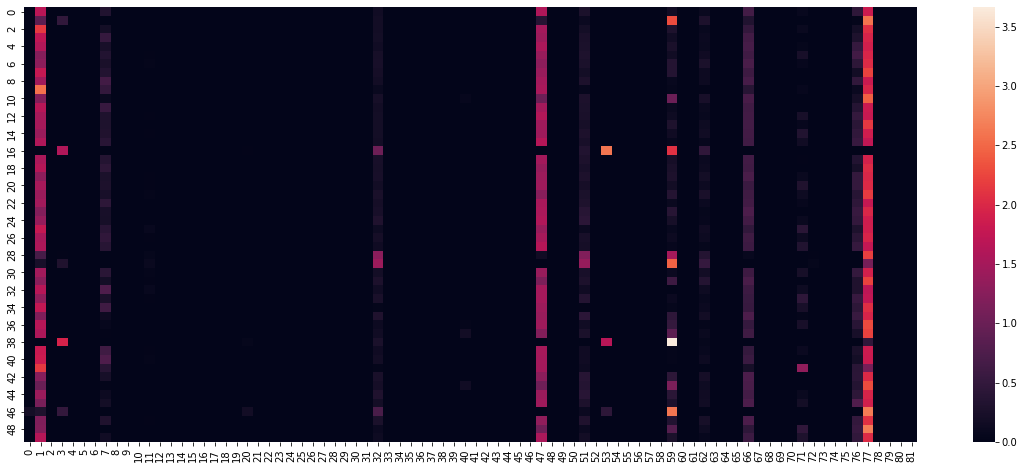

In [22]:
from sklearn.model_selection import KFold
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

import matplotlib.pyplot as plt
import seaborn as sns
import numpy.matlib

tabnet_params = dict(
    cat_idxs=cat_idxs,
    cat_dims=dim_size_,
    cat_emb_dim=5,
    n_d = 8,
    n_a = 8,
    n_steps = 1,
    gamma = 5,
    n_independent = 2,
    n_shared = 2,
    lambda_sparse = 0,
    optimizer_fn = AdamW,
    optimizer_params = dict(lr = (1e-2), weight_decay=0.0),
    mask_type = "entmax",
    scheduler_params = dict(T_0=120, T_mult=1, eta_min=1e-5, last_epoch=-1, verbose=False),
    scheduler_fn = CosineAnnealingWarmRestarts,
    seed = 42,
    verbose = 10
)

kf = KFold(n_splits=5, shuffle=True, random_state=239)

class DevMetric(Metric):
    def __init__(self):
        self._name = "DevMetric"
        self._maximize = False

    def __call__(self, y_true, y_score):
        #print(y_true.shape, y_score.shape, y_true.dtype)
        return metrics_stat(np.expm1(y_true.flatten()), 
                            np.expm1(np.clip(y_score.flatten(),5,15))
                           )['raif_metric']
    
def MAPELoss(y_pred, y_true):
    return torch.mean(torch.abs(y_true - y_pred) / y_true).clone()
    

ifold = 0
for tr,va in kf.split(train_df):
    
    df_tr = train_df.loc[tr].reset_index(drop=True).values
    df_va = train_df.loc[va].reset_index(drop=True).values
    tr_y = np.log1p(train.loc[tr,[TARGET]].values)
    va_y = np.log1p(train.loc[va,[TARGET]].values)
    
    va_y = va_y[train_df.loc[va].price_type.values == 1]
    df_va = df_va[train_df.loc[va].price_type.values == 1]
    
    c_1_tr_y = tr_y[train_df.loc[tr].price_type.values == 1]
    c_1_df_tr = df_tr[train_df.loc[tr].price_type.values == 1]
    
    clf = TabNetRegressor(**tabnet_params)
    
    clf.load_model('model_preproc_'+str(ifold)+'.pth.zip')
    matrix = clf.explain(df_va)
    fig, ax = plt.subplots(figsize=(20,8))
    sns.heatmap(matrix[0][:50], ax=ax)
    print('top (1,47,59,77):', [train_df.columns.tolist()[x] for x in [1,47,59,77]])
    ifold += 1
    break

In [87]:
q = pd.read_csv('oof_ape.csv')
q.head()

,id,ape
0,COL_7,0.105912
1,COL_14,0.494610
2,COL_15,0.128257
3,COL_19,0.201847
4,COL_27,0.113780


In [90]:
q = pd.read_csv('oof_ape.csv')
qq = train[['id','lat','lng','region','price_type']].merge(q, on=['id'], how='left')
qq = qq.loc[qq.price_type==1].reset_index(drop=True)

In [91]:
qq.head()

,id,lat,lng,region,price_type,ape
0,COL_62,56.063615,92.958428,Красноярский край,1,NaN
1,COL_71,51.534581,46.020549,Саратовская область,1,NaN
2,COL_140,56.026884,92.818323,Красноярский край,1,NaN
3,COL_202,52.275528,104.251444,Иркутская область,1,NaN
4,COL_207,50.576545,36.584197,Белгородская область,1,NaN


<AxesSubplot:>

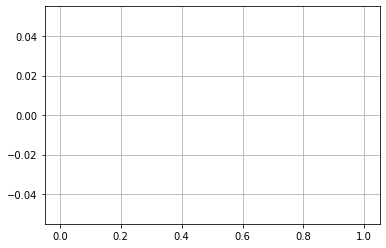

In [85]:
qq.loc[(~qq.ape.isnull()) & (qq.ape < 1.0)].ape.hist(bins=100)

In [75]:
qq.loc[qq.ape<5]

,id,lat,lng,region,ape
0,COL_0,57.998207,56.292797,Пермский край,0.178890
1,COL_1,55.574284,39.543835,Московская область,0.522362
2,COL_2,57.619140,39.850525,Ярославская область,0.137616
3,COL_3,53.897083,87.108604,Кемеровская область,0.177176
4,COL_4,55.802590,37.487110,Москва,0.230602
...,...,...,...,...,...
4863,COL_4947,57.146690,65.558210,Тюменская область,0.511473
4869,COL_4953,59.762043,30.775509,Ленинградская область,0.140772
4872,COL_4956,55.781570,49.221012,Татарстан,0.028213
4902,COL_4986,43.598820,39.734478,Краснодарский край,0.540550


In [77]:
qq.dropna().groupby('region').agg({
    'ape': ['min','median','max'],
    'lat': ['mean'],
    'lng': ['mean']
})

ape                     
                              min    median        max
region                                                
Адыгея                   0.003649  0.170687   0.738122
Алтайский край           0.000020  0.183241   0.794808
Башкортостан             0.001096  0.169073   1.136850
Белгородская область     0.001472  0.133173   0.635992
Брянская область         0.003495  0.161041   0.395673
Волгоградская область    0.002655  0.146005   0.980736
Вологодская область      0.007530  0.159580   1.373365
Воронежская область      0.005865  0.147466   0.847935
Ивановская область       0.000750  0.168705   0.736699
Иркутская область        0.004840  0.140809   0.940334
Калининградская область  0.019832  0.233594   0.750945
Калужская область        0.002832  0.228272   0.697657
Карелия                  0.014848  0.098491   0.293388
Кемеровская область      0.000365  0.187301   1.145736
Кировская область        0.002591  0.151604   0.483889
Коми                     0.004938  0.104168   0.928207
Костромская область      0.027894  0.135888   0.430941
Краснодарский край       0.000056  0.176116   1.926528
Красноярский край        0.000429  0.151420   1.168685
Курская область          0.023265  0.155630   0.338877
Ленинградская область    0.005780  0.172924   0.596592
Липецкая область         0.008154  0.100092   0.392411
Мордовия                 0.000872  0.093276   0.527207
Москва                   0.000102  0.159822  37.365145
Московская область       0.000498  0.130946   3.595641
Нижегородская область    0.000737  0.145651   0.947576
Новосибирская область    0.003976  0.130525   1.012534
Омская область           0.005610  0.158135   0.489489
Орловская область        0.004617  0.110971   0.366307
Пензенская область       0.003898  0.215192   0.920008
Пермский край            0.000436  0.173292   1.228644
Приморский край          0.127648  0.256389   0.427852
Ростовская область       0.001178  0.164490   1.099236
Самарская область        0.000626  0.202492   8.648157
Санкт-Петербург          0.002262  0.157173   0.997174
Саратовская область      0.002841  0.161789   0.917581
Свердловская область     0.000025  0.169963   1.254807
Смоленская область       0.003097  0.117052   0.597032
Ставропольский край      0.000062  0.148524   1.288012
Татарстан                0.001618  0.164041   0.912709
Томская область          0.002896  0.152359   0.353450
Тульская область         0.010918  0.206774   1.007695
Тюменская область        0.001148  0.193690   1.005652
Удмуртия                 0.007922  0.140644   0.968181
Ульяновская область      0.006895  0.202780   0.962737
Ханты-Мансийский АО      0.010921  0.123843   0.683326
Челябинская область      0.001042  0.170568   0.931807
Ярославская область      0.000402  0.119584   0.589745

In [36]:
qq = qq.loc[(qq['ape'] <= 1.0) & (~qq['ape'].isnull())].reset_index(drop=True)
qq['size'] = (qq['ape']*100).astype(int)

In [41]:
qq['error'] = qq['size']

In [43]:
!pip install geopandas 

In [54]:
world

{'_is_copy': None,
 '_mgr': BlockManager
 Items: Index(['OBJECTID', 'CNTRY_NAME', 'geometry'], dtype='object')
 Axis 1: RangeIndex(start=0, stop=251, step=1)
 NumericBlock: slice(0, 1, 1), 1 x 251, dtype: int64
 ObjectBlock: slice(1, 2, 1), 1 x 251, dtype: object
 ExtensionBlock: slice(2, 3, 1), 1 x 251, dtype: geometry,
 '_item_cache': {'geometry': 0      POLYGON ((-69.88223 12.41111, -69.94695 12.436...
  1      MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ...
  2      POLYGON ((61.27656 35.60725, 61.29638 35.62853...
  3      POLYGON ((-5.15213 30.18047, -5.13917 30.19236...
  4      MULTIPOLYGON (((45.02583 41.03055, 45.00999 41...
                               ...                        
  246    MULTIPOLYGON (((-172.59650 -13.50911, -172.551...
  247    POLYGON ((30.89944 -26.77195, 30.88028 -26.793...
  248    MULTIPOLYGON (((48.68639 14.03750, 48.61000 14...
  249    POLYGON ((30.21302 -14.98172, 30.21917 -15.096...
  250    POLYGON ((32.48888 -21.34445, 32.46541 -21.325...
 

In [56]:
russia = world[world['name']=='Russia']

KeyError: 'name'

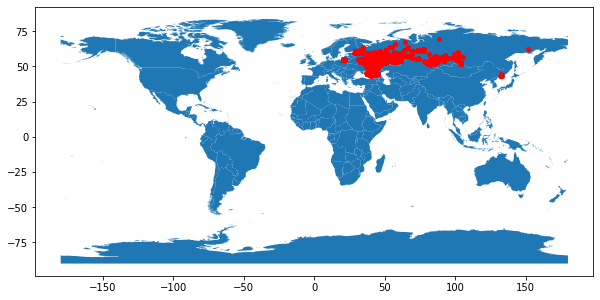

In [55]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geopandas
#import geoplot

#url = "https://opendata.arcgis.com/datasets/a21fdb46d23e4ef896f31475217cbb08_1.geojson"
#world = gpd.read_file(url)
#world = world['Russia']

geometry = [Point(xy) for xy in zip(qq['lng'], qq['lat'])]
gdf = GeoDataFrame(qq, geometry=geometry)   

#this is a simple map that goes with geopandas
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [73]:
!pip install basemap

ERROR: Could not find a version that satisfies the requirement basemap (from versions: none)
ERROR: No matching distribution found for basemap


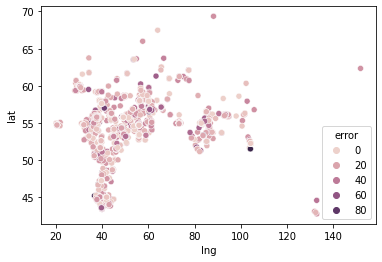

In [72]:
import matplotlib

ax = sns.scatterplot(
    data=qq, x="lng", y="lat", hue="error"
)
ax.set_yscale("linear")


#ax.invert_yaxis()
#ax.invert_xaxis()

In [40]:
[train_df.columns.tolist()[x] for x in [1,7,47,71]]

['floor', 'osm_amenity_points_in_0.01', 'osm_offices_points_in_0.01', 'street']

/home/serg/.cache/pypoetry/virtualenvs/raif-hack-mbpgJqVD-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lng', ylabel='lat'>

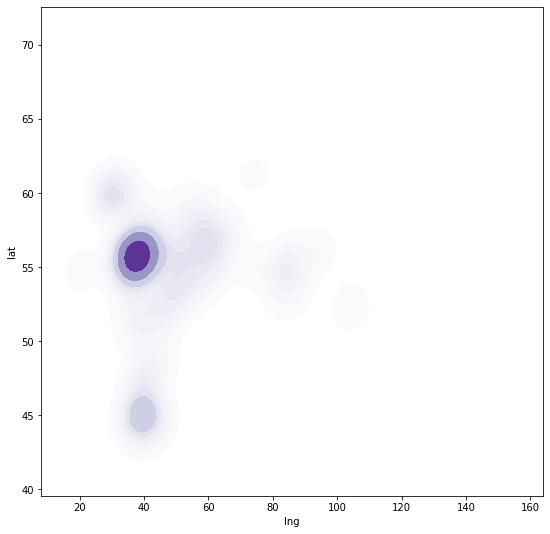

In [61]:
f, ax = plt.subplots(1, figsize=(9, 9))
sns.kdeplot(qq['lng'], qq['lat'], \
            shade=True, cmap='Purples', \
            ax=ax, zorder=100)


In [20]:
from sklearn.model_selection import KFold
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

tabnet_params = dict(
    cat_idxs=cat_idxs,
    cat_dims=dim_size_,
    cat_emb_dim=5,
    n_d = 8,
    n_a = 8,
    n_steps = 1,
    gamma = 5,
    n_independent = 2,
    n_shared = 2,
    lambda_sparse = 0,
    optimizer_fn = AdamW,
    optimizer_params = dict(lr = (1e-2), weight_decay=0.0),
    mask_type = "entmax",
    scheduler_params = dict(T_0=120, T_mult=1, eta_min=1e-5, last_epoch=-1, verbose=False),
    scheduler_fn = CosineAnnealingWarmRestarts,
    seed = 42,
    verbose = 10
)

kf = KFold(n_splits=5, shuffle=True, random_state=239)

class DevMetric(Metric):
    def __init__(self):
        self._name = "DevMetric"
        self._maximize = False

    def __call__(self, y_true, y_score):
        #print(y_true.shape, y_score.shape, y_true.dtype)
        return metrics_stat(np.expm1(y_true.flatten()), 
                            np.expm1(np.clip(y_score.flatten(),5,15))
                           )['raif_metric']
    
def MAPELoss(y_pred, y_true):
    return torch.mean(torch.abs(y_true - y_pred) / y_true).clone()
    

ifold = 0
for tr,va in kf.split(train_df):
    df_tr = train_df.loc[tr].reset_index(drop=True).values
    df_va = train_df.loc[va].reset_index(drop=True).values
    tr_y = np.log1p(train.loc[tr,[TARGET]].values)
    va_y = np.log1p(train.loc[va,[TARGET]].values)
    
    va_y = va_y[train_df.loc[va].price_type.values == 1]
    df_va = df_va[train_df.loc[va].price_type.values == 1]
    
    c_1_tr_y = tr_y[train_df.loc[tr].price_type.values == 1]
    c_1_df_tr = df_tr[train_df.loc[tr].price_type.values == 1]
    
    clf = TabNetRegressor(**tabnet_params)
    clf.fit(
      df_tr, tr_y,
      eval_set=[(c_1_df_tr, c_1_tr_y), (df_va, va_y)],
      max_epochs = 120,
      patience = 15,
      batch_size = 256, 
      virtual_batch_size = 256,
      num_workers = 4,
      drop_last = False,
      eval_metric=[DevMetric],
      loss_fn=MAPELoss
    )
    clf.save_model('model_preproc_'+str(ifold)+'.pth')
    ifold += 1

Device used : cuda
epoch 0  | loss: 0.13052 | val_0_DevMetric: 2.16821 | val_1_DevMetric: 2.05997 |  0:00:13s
epoch 10 | loss: 0.04274 | val_0_DevMetric: 1.54192 | val_1_DevMetric: 1.69678 |  0:02:33s
epoch 20 | loss: 0.03998 | val_0_DevMetric: 1.76415 | val_1_DevMetric: 1.92404 |  0:04:54s

Early stopping occurred at epoch 29 with best_epoch = 14 and best_val_1_DevMetric = 1.45183
Best weights from best epoch are automatically used!
Successfully saved model at model_preproc_0.pth.zip
Device used : cuda
epoch 0  | loss: 0.13099 | val_0_DevMetric: 2.19852 | val_1_DevMetric: 2.29357 |  0:00:14s
epoch 10 | loss: 0.04274 | val_0_DevMetric: 1.43621 | val_1_DevMetric: 1.9091  |  0:02:41s
epoch 20 | loss: 0.03982 | val_0_DevMetric: 1.40056 | val_1_DevMetric: 2.05384 |  0:05:03s

Early stopping occurred at epoch 20 with best_epoch = 5 and best_val_1_DevMetric = 1.89629
Best weights from best epoch are automatically used!
Successfully saved model at model_preproc_1.pth.zip
Device used : cuda
ep

In [21]:
from sklearn.model_selection import KFold
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

pred = 0
for ifold in range(5):
    clf = TabNetRegressor(**tabnet_params)
    clf.load_model('model_preproc_'+str(ifold)+'.pth.zip')
    y_score = clf.predict(test_df.values)
    y_score = np.clip(y_score.flatten(),5,15)
    pred += np.expm1(y_score) * 0.2
test_sub = pd.read_csv('../data/test.csv')[['id']]
test_sub[TARGET] = pred
test_sub.to_csv('tabnet_preproc_new_loss.csv', index=False)

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda


In [22]:
test_sub.head()

,id,per_square_meter_price
0,COL_289284,38539.027344
1,COL_289305,51784.941406
2,COL_289318,36924.695312
3,COL_289354,68011.429688
4,COL_289399,48563.992188
